In [44]:
import pandas as pd

data = pd.read_csv('/home/cakaltc1/Development/projects/application_files/experiments/ip_accounts_hiar_tfidf/generated_files/20171004/246_calculated_tfidf_for_term_value_matrix.csv')

In [45]:
from sklearn import preprocessing

accounts = data['AccountID']
del data['AccountID']

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
#data_n = pd.DataFrame(np_scaled)
data_n = data
data_n = data_n.astype('float32')

feature_size = len(data.columns)
print('Feature Size: ', feature_size)

#before applied scaling
print(data['stent_des_cathlab_27x'].head())
#after applied scaling
# print(data_n[299].head()) #->stent_des_cathlab_27x

Feature Size:  309
0    0.805482
1    0.805482
2    0.805482
3    0.805482
4    0.000000
Name: stent_des_cathlab_27x, dtype: float64


In [82]:
import numpy as np
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
import math

batch_size = 100
original_dim = feature_size
latent_dim = math.floor(feature_size * .1)
intermediate_dim = math.floor(feature_size * .5)
epochs = 500
epsilon_std = 1.0

print("latent dim:", latent_dim)

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

#learning 
vae.fit(data_n.values,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)

encoder = Model(x, z_mean)
x_test_encoded = encoder.predict(data_n.values, batch_size=batch_size)

decoder_input = Input(shape=(latent_dim,))
print('decoder_input.shape:', decoder_input.shape)

_h_decoded = decoder_h(decoder_input)
print('_h_decoded.shape:', _h_decoded.shape)

_x_decoded_mean = decoder_mean(_h_decoded)
print('_x_decoded_mean.shape:', _x_decoded_mean.shape)

generator = Model(decoder_input, _x_decoded_mean)




latent dim: 30


/home/cakaltc1/Development/projects/github/py3_machine_learning/venv/lib/python3.5/site-packages/ipykernel_launcher.py:59: UserWarning: Output "custom_variational_layer_8" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_8" during training.


decoder_input.shape: (?, 30)
_h_decoded.shape: (?, 154)
_x_decoded_mean.shape: (?, 309)


In [83]:
#EVALUATION

encoded = encoder.predict(data_n.values)
decoded = generator.predict(encoded)

In [84]:
import numpy as np

dist = np.zeros(len(data_n.values))
for i, x in enumerate(data_n.values):
    dist[i] = np.linalg.norm(x-decoded[i]) # euclidean distance

In [85]:
import matplotlib.pyplot as plt
def compute_error_per_dim(point):
    p = np.array(data_n.iloc[point,:]).reshape(1,feature_size)
    encoded = encoder.predict(p)
    decoded = generator.predict(encoded)
    return np.array(p - decoded)[0]

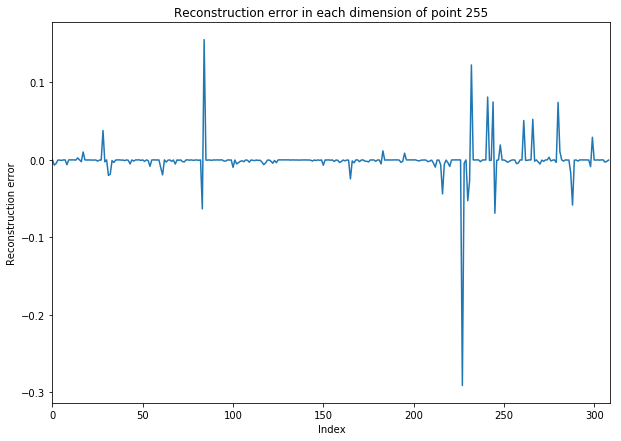

In [92]:
#print(compute_error_per_dim(1))

account_index = 255
plt.figure(figsize=(10,7))
plt.plot(compute_error_per_dim(account_index))
plt.xlim((0,feature_size))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point " + str(account_index))
plt.savefig("ae-outlier-reconstruction-"+str(account_index)+".svg", format="svg")
plt.show()


In [93]:
# Return a list of the dimensions with the highest reconstruction error
top10_features = np.argsort(compute_error_per_dim(account_index))[::-1][0:5]
print(top10_features)

[ 84 232 241 244 280]


In [109]:
list(data.columns).index("stent_des_cathlab_27x")
print(data.columns[84])

5824_93459_cathlab_481


In [110]:
print('Account:',accounts[117])
data.iloc[117]['5824_93459_cathlab_481']

Account: 630959


0.20830798678378976